<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [9]:
import re
import string
from bs4 import BeautifulSoup as bs
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

In [2]:
# Indeed url
city = 'Tucson'
state = 'AZ'
keywords = 'data+science'
indeed = 'https://www.indeed.com/jobs?q={keywords}&l={city}%2C+{state}'

## 1) *Optional:* Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

If you choose to not to scrape the data, there is a CSV with outdated data in the directory. Remeber, if you scrape Indeed, you're helping yourself find a job. ;)

In [3]:
data = pd.read_csv('data/job_listings.csv')
data.head()

,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


## 2) Use Spacy to tokenize / clean the listings 

In [4]:
# Drop Unnamed column
data = data.drop(columns='Unnamed: 0')

In [10]:
data['description'] = data['description'].apply(lambda x: bs(x).get_text().replace("\\n", " " ).strip("b'").lower())

In [15]:
nlp = spacy.load('en_core_web_lg')

STOPWORDS = nlp.Defaults.stop_words
def get_lemmas(text):

    lemmas = []
    

    doc = nlp(text)
    

    for token in doc: 
        if ((token.text not in STOPWORDS) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas

In [16]:
data['tokens'] = data['description'].apply(get_lemmas)

data.head()

,description,title,tokens
0,"""job requirements: conceptual understanding in...",Data scientist,"[job, requirement, conceptual, understanding, ..."
1,"job description as a data scientist 1, you wi...",Data Scientist I,"[job, description, , data, scientist, 1, help..."
2,as a data scientist you will be working on con...,Data Scientist - Entry Level,"[data, scientist, work, consult, business, res..."
3,"$4,969 - $6,756 a monthcontractunder the gener...",Data Scientist,"[$, 4,969, $, 6,756, monthcontractunder, gener..."
4,location: usa \xe2\x80\x93 multiple locations ...,Data Scientist,"[location, usa, \xe2\x80\x93, multiple, locati..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [17]:
from collections import Counter

word_counts = Counter()
data['tokens'].apply(lambda x: word_counts.update(x))

word_counts.most_common(20)

[('datum', 3275),
 (' ', 2225),
 ('experience', 1933),
 ('work', 1645),
 ('team', 1352),
 ('business', 1263),
 ('data', 1170),
 ('science', 988),
 ('product', 893),
 ('model', 854),
 ('analytic', 838),
 ('analysis', 812),
 ('skill', 721),
 ('machine', 707),
 ('learning', 702),
 ('scientist', 701),
 ('build', 634),
 ('develop', 624),
 ('opportunity', 583),
 ('solution', 580)]

In [18]:
data['joined_tokens'] = data['tokens'].apply(lambda x: " ".join(x))

vect = CountVectorizer(stop_words='english')
vect.fit(data['joined_tokens'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [19]:
col=vect.get_feature_names()
sparse_dtm = vect.transform(data['joined_tokens'])
dtm = pd.DataFrame(sparse_dtm.todense(), columns = col)
dtm.shape

(426, 6798)

In [20]:
dtm.head()

,00,000,02115,03,0305,0356,04,062,06366,08,...,zero,zeus,zf,zheng,zillow,zogsport,zone,zoom,zuckerberg,zurich
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

In [21]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [22]:
wc = count(data['tokens'])

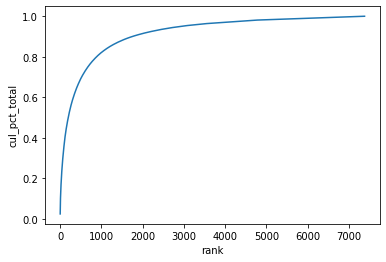

In [23]:

import seaborn as sns

# Cumulative Distribution Plot
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

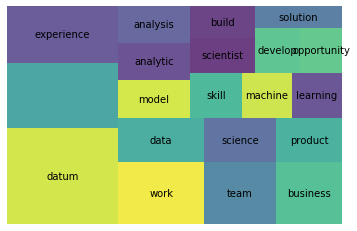

In [24]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words = 'english')

# Create a vocabulary and get word counts per document
sparse = tfidf.fit_transform(data['joined_tokens'])

# Print word counts

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(sparse.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm.head()

,00,000,02115,03,0305,0356,04,062,06366,08,...,zero,zeus,zf,zheng,zillow,zogsport,zone,zoom,zuckerberg,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.110858,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [26]:

# Instantiate
from sklearn.neighbors import NearestNeighbors


# Fit on TF-IDF Vectors
nn  = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [27]:
nn.kneighbors(dtm)

(array([[0.        , 1.27722044, 1.3012403 , 1.30773534, 1.30990816],
        [0.        , 1.22369711, 1.23218554, 1.23221478, 1.23787191],
        [0.        , 1.22653298, 1.2268518 , 1.23243903, 1.24551948],
        ...,
        [0.        , 0.        , 1.28217565, 1.29431334, 1.29508848],
        [0.        , 0.03670868, 1.19328849, 1.23348635, 1.23407911],
        [0.        , 1.23160662, 1.25136986, 1.25461507, 1.25743634]]),
 array([[  0, 276, 274, 336, 366],
        [  1, 201, 216, 351, 399],
        [  2, 318, 307, 407, 357],
        ...,
        [ 44, 423, 363, 397, 110],
        [424, 382, 201, 366, 383],
        [425, 201, 406, 292, 264]], dtype=int64))

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 